### The model

$u(c) = log(c)$ utility function    
$y = 1$ Deterministic income    
$p(r = 0.02) = 0.5$   
$p(r = -0.01) = 0.5$ 

### value iteration 

In [1]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
def u(c):
    return np.log(c)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# discounting factor 
beta = 0.95
# wealth level
w_low = 1
w_high = 10
# interest rate
r_up = 0.02
r_down = 0.01
# deterministic income
y = 1
# good state and bad state economy with equal probability 0.5
# with good investment return 0.02 or bad investment return -0.01
ws = np.linspace(0.01,10**(0.5),100)**2
Vs = np.zeros(100)
Cs = np.zeros(100)

In [3]:
# Value iteration
for j in range(30):
    if j % 10 == 0:
        print(j)
    for i in range(len(ws)):
        w = ws[i]
        def obj(c):
            return -(u(c) + beta*(np.interp((y+w-c)*(1+r_up), ws, Vs) + np.interp((y+w-c)*(1-r_down), ws, Vs))/2)
        bounds = [(0.0001, y+w-0.0001)]
        res = minimize(obj, 0.0001, method='SLSQP', bounds=bounds)
        Cs[i] = res.x[0]
        Vs[i] = -res.fun

0
10
20


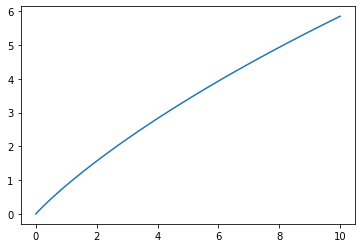

In [4]:
plt.plot(ws,Vs)

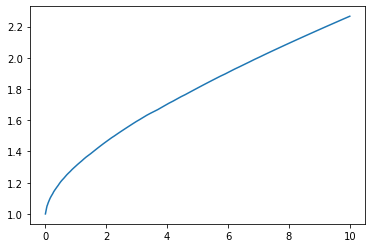

In [5]:
plt.plot(ws,Cs)

### policy gradient
Assume the policy form $\theta = (a,b,c, \sigma =0.1)$, then $\pi_\theta$ ~ $N(log(ax+b)+c, \sigma)$

Assume the initial value $a = 1$, $b = 1$, $c = 1$, $\sigma = 0.1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [6]:
# simulation step T = 20
T = 20
def mu(theta, w):
    return np.log(theta[0] * w + theta[1]) + theta[2] 

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.choice(ws)
    for t in range(T):
        c = np.random.normal(mu(theta, w), theta[3])
        while c < 0.001 or c > w+y-0.001:
            c = np.random.normal(mu(theta, w), theta[3])
        wPath[t] = w
        aPath[t] = c
        try:
            rPath[t] = np.log(c)*(beta**t)
        except:
            print(c)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath


def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    grad = np.zeros(len(theta))
    newGrad = np.zeros(len(theta))
    for d in range(D):
        wp, ap, rp = simSinglePath(theta) 
        newGrad[0] = np.sum((ap - mu(theta, wp))/(theta[3]**2)*(wp/(theta[0]*wp + theta[1])))
        newGrad[1] = np.sum((ap - mu(theta, wp))/(theta[3]**2)*(1/(theta[0]*wp + theta[1])))
        newGrad[2] = np.sum((ap - mu(theta, wp))/(theta[3]**2))
        grad += newGrad * np.sum(rp)
    grad /= D
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 


def plot(theta):
    def f(x):
        return np.log(theta[0]*x + theta[1]) + theta[2]
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, f(ws), 'r')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


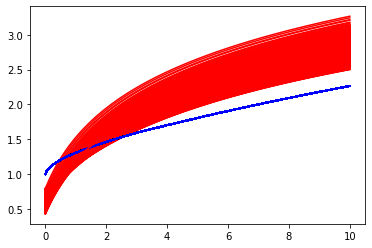

In [7]:
# c < 0 or c > w + 5, then reward -100
N = 4000
# initial theta
theta = [1,1,1,0.2]
# gradient ascend step size
alpha = 0.001
# store theta
THETA = np.zeros((3,N))
for i in range(N):
    if i%100 ==0:
        print(i)
    theta = updateTheta(theta)
    THETA[:,i] = theta[:3]
    plot(theta)

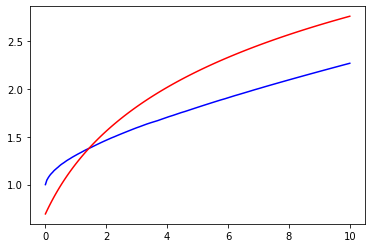

In [8]:
plot(theta)

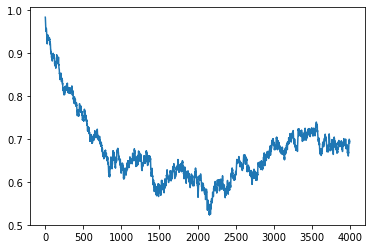

In [9]:
plt.plot(THETA[0,:])

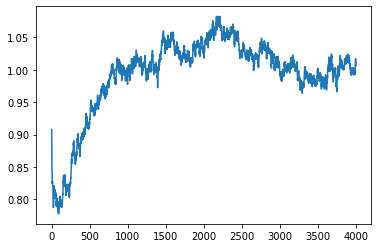

In [10]:
plt.plot(THETA[1,:])

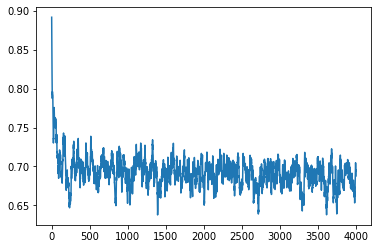

In [11]:
plt.plot(THETA[2,:])

### policy gradient
Assume the policy form $\theta = (a,b,\sigma = 0.1)$, then $\pi_\theta$ ~ $N(ax+b, \sigma)$

Assume the initial value $a = 1$, $b = 1$, $\sigma = 0.1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [12]:
# simulation step T = 20
def mu(theta, w):
    return theta[0] * w + theta[1]

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.choice(ws)
    for t in range(T):
        c = np.random.normal(mu(theta, w), theta[2])
        while c < 0.0001 or c > w+y-0.0001:
            c = np.random.normal(mu(theta, w), theta[2])
        wPath[t] = w
        aPath[t] = c
        rPath[t] = np.log(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath


def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    grad = np.zeros(len(theta))
    newGrad = np.zeros(len(theta))
    for d in range(D):
        wp, ap, rp = simSinglePath(theta) 
        newGrad[0] = np.sum((ap - mu(theta, wp))/(theta[2]**2)*(wp))
        newGrad[1] = np.sum((ap - mu(theta, wp))/(theta[2]**2)*(1))
        grad += newGrad * np.sum(rp)
    grad /= D
    return grad


def plot(theta):
    def f(x):
        return theta[0] * x + theta[1]
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, f(ws), 'r')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


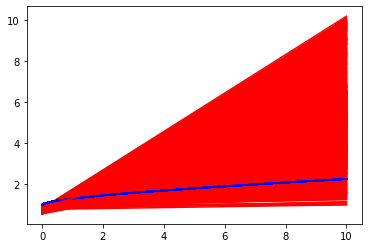

In [25]:
# c < 0 or c > w + 5, then reward -100
# initial theta 
N = 1500
theta = [1,1,0.1]
# gradient ascend step size 
alpha = 0.001
# store theta 
THETA = np.zeros((2,N))
for i in range(N):
    if i%100 ==0:
        print(i)
    theta = updateTheta(theta)
    THETA[:,i] = theta[:2]
    plot(theta)

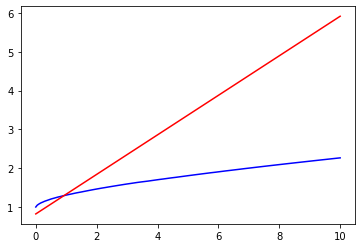

In [26]:
plot(theta)

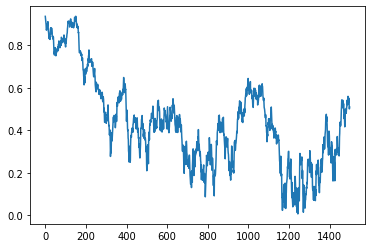

In [27]:
plt.plot(THETA[0,:])

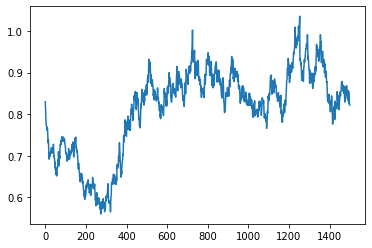

In [28]:
plt.plot(THETA[1,:])